In [4]:
import sys
sys.path.append('../Codes/library/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import scipy.special as sc
import pandas as pd
from functions import*
N_A = 6.02214076e23
Text_files_path = '/Users/robertomorantovar/Dropbox/Research/Evolution_Immune_System/Text_files/'

%autosave 60

Autosaving every 60 seconds


In [20]:
N_r = 5e5
T0 = 0
Tf = 8
dT = .01
days = np.arange(0, Tf, 1)
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
time_bins = time[::10]
lambda_A = 6 #days^-1
k_pr = .1 # hour^-1
k_pr = k_pr*24 #days^-1
qs = [1, 2, 3]
colors_q = ['darkred', 'olive', 'navy']
lambda_B = 1*lambda_A
k_on = 1e6*24*3600; #(M*days)^-1
N_c = 1e4
E_ms = -28

E_t = lambda t, q:lambda_A*t/q - np.log((lambda_A*N_A)/(k_on*N_c))/q + np.log(k_pr/k_on) 

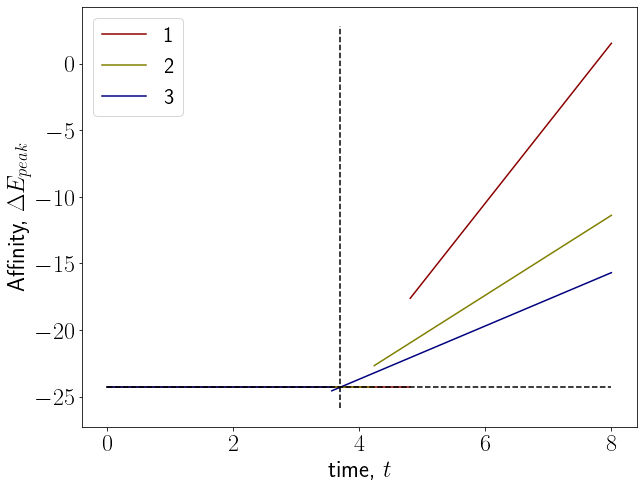

In [21]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})
t_prime = 1/lambda_A*np.log((lambda_A*N_A)/(k_on*N_c))
E_q = [-17.62, -22.68, -24.57]

for i, q in enumerate(qs):
    delta_t_q = (E_q[i]+24.31)*q/lambda_A
    t_q = t_prime + delta_t_q
    time1 = np.linspace(0, t_q, 100)
    time2 = np.linspace(t_q, 8, 100)
    ax.plot(time1, np.ones_like(time1)*E_t(t_prime, q), color = colors_q[q-1])
    ax.plot(time2, E_t(time2, q) , label = '%d'%q, color = colors_q[q-1])
    

ax.vlines(t_prime, ax.get_ylim()[0], ax.get_ylim()[1], color = 'black', linestyle = '--')
ax.hlines(np.log(k_pr/k_on), time[0], time[-1], color = 'black', linestyle = '--')
ax.legend(fontsize = 22)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'Affinity, $\Delta E_{peak}$')


(-27.31112311961889, -10.0)

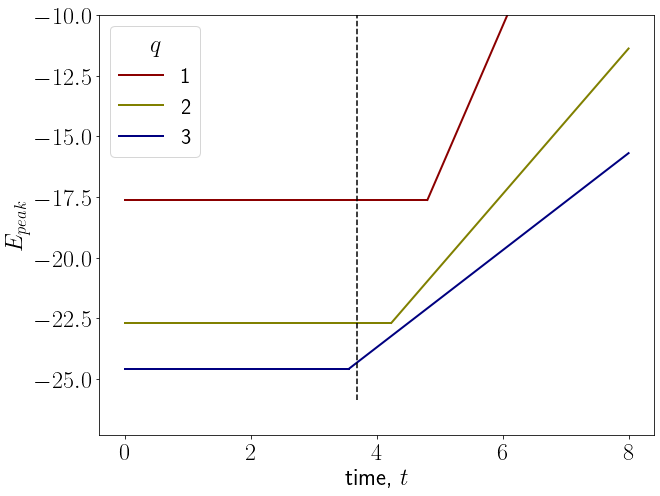

In [22]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})

for i, q in enumerate(qs):
    delta_t_q = (E_q[i]+24.31)*q/lambda_A
    t_q = t_prime + delta_t_q
    time1 = np.linspace(0, t_q, 100)
    time2 = np.linspace(t_q, 8, 100)
    
    deltaE = E_t(time2, q) - E_q[i]
    E_peak = E_q[i]+deltaE
    E_peak = E_q[i]+lambda_A*(time2-t_q)/q
    plot1 = ax.plot(time1, np.ones_like(time1)*E_q[i], linewidth = 2, color = colors_q[i])
    ax.plot(time2, E_peak, label = '%d'%q, linewidth = 2, color = colors_q[i])

ax.vlines(t_prime, ax.get_ylim()[0], ax.get_ylim()[1], color = 'black', linestyle = '--')
#ax.hlines(E_r, time1[0], time2[-1], color = 'black', linestyle = '--', linewidth = 2)
ax.legend(fontsize = 22, title = r'$q$', title_fontsize = 24)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'$E_{peak}$')
ax.set_ylim(top = -10)

In [23]:
M1 = np.loadtxt(Text_files_path+'MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt(Text_files_path+'MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt(Text_files_path+'BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)

Matrix = 'MJ2'
#Matrix = 'MM'

if(Matrix == 'MJ2'):
    M2 = np.loadtxt(Text_files_path + Matrix + '.txt', skiprows= 1, usecols=range(1,21))
    Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)
    Alphabet_list = Alphabet.tolist()

colors = ['tab:blue','tab:red']
N_ens = 500
N_rs = np.logspace(5, 12, 10)
T0 = 0
Tf = 7.9
dT = .01
days = np.arange(0, Tf, 1)
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
time_bins = time[::5]
lambda_A = 6 #days^-1
k_pr = .1 # hour^-1
k_pr = k_pr*24 #days^-1
qs = np.linspace(1, 2.5, 15)
lambda_B = 1*lambda_A
k_on = 1e6*24*3600; #(M*days)^-1
N_c = 1e4
E_ms = -28

antigen = 'TACNSEYPNTTKCGRWYC'
L=len(antigen)

#----------------------------------------------------------------

antigen_list = [i for i in antigen]
antigen_seq = np.array([], dtype = int)
for i, aa in enumerate(antigen_list):
    index = Alphabet_list.index(aa)
    antigen_seq = np.append(antigen_seq, int(index))
PWM_data = M2[:,antigen_seq]

#Change values by the minimum
for i in np.arange(L):
    PWM_data[:,i]-=np.min(PWM_data[:,i], axis=0)

Es, dE, Q0, lambdas = calculate_Q0(0.01, 50, 200000, PWM_data, E_ms, L)
S = np.cumsum(lambdas[:-1]*dE)
Omega = np.sum(np.exp(S)*dE)
Ks = np.exp(Es[:-1])

beta_pr = lambdas[:-1][Es[:-1]<np.log(k_pr/k_on)][-1]
E_pr = Es[:-1][Es[:-1]<np.log(k_pr/k_on)][-1]
print('E_pr:%.2f'%E_pr, 'beta_pr:%.2f'%beta_pr)

#----------------------------------------------------------------


E_pr:-24.31 beta_pr:2.99


<timed exec>:33: RuntimeWarning: divide by zero encountered in log
<timed exec>:33: RuntimeWarning: invalid value encountered in multiply
<timed exec>:33: RuntimeWarning: divide by zero encountered in log
<timed exec>:33: RuntimeWarning: invalid value encountered in multiply
<timed exec>:33: RuntimeWarning: divide by zero encountered in log
<timed exec>:33: RuntimeWarning: invalid value encountered in multiply
<timed exec>:33: RuntimeWarning: divide by zero encountered in log
<timed exec>:33: RuntimeWarning: invalid value encountered in multiply
<timed exec>:33: RuntimeWarning: divide by zero encountered in log
<timed exec>:33: RuntimeWarning: invalid value encountered in multiply


CPU times: user 1min 56s, sys: 4.64 s, total: 2min 1s
Wall time: 2min 8s


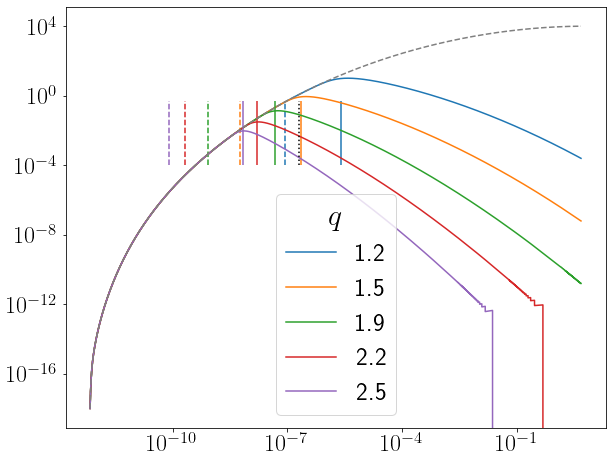

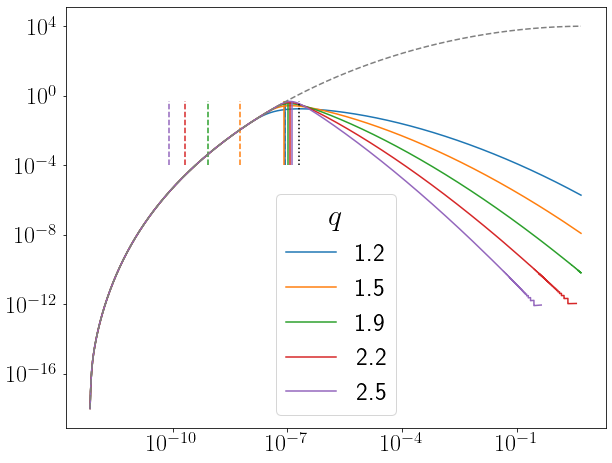

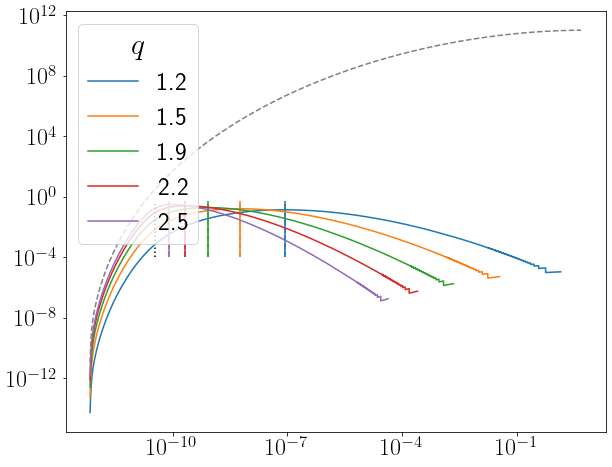

In [24]:
%%time
times_act = np.zeros((len(N_rs), len(qs)))
Es_act = np.zeros_like(times_act)
betas_act = np.zeros_like(times_act)

Ds_KL_f = np.ones_like(times_act)
Ds_KL_act = np.ones_like(times_act)

Es_q = np.zeros(len(qs))
Es_r = np.zeros(len(N_rs))

betas_q = np.zeros(len(qs))
betas_r = np.zeros(len(N_rs))

fig_f, ax_f = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
fig_act1, ax_act1 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
fig_act2, ax_act2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})

qs_opt = np.ones_like(N_rs)

for i_N_r, N_r in enumerate(N_rs):
    beta_r = lambdas[:-1][np.cumsum(Q0*dE)<(1/N_r)][-1]
    E_r = Es[:-1][np.cumsum(Q0*dE)<(1/(N_r))][-1]
    Es_r[i_N_r] = E_r
    betas_r[i_N_r] = beta_r
    qs_opt[i_N_r] = beta_r
    for i_q, q in enumerate(qs):
        beta_q = lambdas[lambdas>q][-1]
        E_q = Es[lambdas>q][-1]
        Es_q[i_q] = E_q
        betas_q[i_q] = beta_q
        
        u_on_f, p_a, R_f, QR_f = calculate_QR(Q0, k_on, k_pr, np.exp(lambda_A*6.0)/N_A, Es, q, lambda_A, N_c, dE) 
        D_KL_f = np.sum(dE*(QR_f/np.sum(QR_f*dE))*(np.log((QR_f/np.sum(QR_f*dE)))-np.log(Q0)))
        
        m_bar = np.array([N_r*(np.sum((1-np.exp(-(np.exp(lambda_A*t)/N_A)*k_on*p_a*N_c/lambda_A))*Q0*dE)) for t in time])
        t_act_theory = time[m_bar>1][0]
        
        u_on_act, p_a, R_f, QR_act = calculate_QR(Q0, k_on, k_pr, np.exp(lambda_A*t_act_theory)/N_A, Es, q, lambda_A, N_c, dE) 
        dE_temp = dE[QR_act!=0]
        Q0_temp = Q0[QR_act!=0]
        Ks_temp = Ks[QR_act!=0]
        QR_act = QR_act[QR_act!=0]
        
        D_KL_act = np.sum(dE_temp*(QR_act/np.sum(QR_act*dE_temp))*(np.log((QR_act/np.sum(QR_act*dE_temp)))-np.log(Q0_temp)))
        
        times_act[i_N_r, i_q] = t_act_theory
        Ds_KL_f[i_N_r, i_q] = D_KL_f
        Ds_KL_act[i_N_r, i_q] = D_KL_act
        Es_act[i_N_r, i_q] = np.max([E_q, E_r])
        betas_act[i_N_r, i_q] = np.min([beta_r, beta_q])
        
        E_peak = np.max([E_t(t_act_theory, q), E_q])
        E_peak_f = np.max([E_t(6.0, q), E_q])
        
        if((i_N_r==0) and (i_q%3==2)):
            plot_f = ax_f.plot(Ks, N_r*QR_f, label = '%.1f'%q)
            plot_act1 = ax_act1.plot(Ks_temp, N_r*QR_act, label = '%.1f'%q)
            
            ax_f.vlines(np.exp(E_q), 0.0001, .5, color = plot_f[0].get_color(), linestyle = '--')
            ax_act1.vlines(np.exp(E_q), 0.0001, .5, color = plot_act1[0].get_color(), linestyle = '--')
            ax_f.vlines(np.exp(E_peak_f), 0.0001, .5, color = plot_f[0].get_color())
            ax_act1.vlines(np.exp(E_peak), 0.0001, .5, color = plot_act1[0].get_color())

        if((i_N_r==(len(N_rs)-1)) and (i_q%3==2)):
            plot_act2 = ax_act2.plot(Ks_temp, N_r*QR_act, label = '%.1f'%q)
            
            ax_act2.vlines(np.exp(E_q), 0.0001, .5, color = plot_act2[0].get_color(), linestyle = '--')
            ax_act2.vlines(np.exp(E_peak), 0.0001, .5, color = plot_act2[0].get_color())

            
            
ax_f.vlines(np.exp(Es_r[0]), 0.0001, .5, color = 'k', linestyle = ':')
ax_act1.vlines(np.exp(Es_r[0]), 0.0001, .5, color = 'k', linestyle = ':')
ax_act2.vlines(np.exp(Es_r[-1]), 0.0001, .5, color = 'k', linestyle = ':')

ax_f.plot(Ks, Q0*N_rs[0], linestyle = '--', color = 'gray')

my_plot_layout(ax=ax_f, xscale = 'log')
my_plot_layout(ax=ax_act1, xscale = 'log')
my_plot_layout(ax=ax_act2, xscale = 'log')

ax_f.legend(title = r'$q$', title_fontsize = 30, fontsize = 25)
ax_act1.legend(title = r'$q$', title_fontsize = 30, fontsize = 25)
ax_act2.legend(title = r'$q$', title_fontsize = 30, fontsize = 25)

fig_f.savefig('../Figures/7_Recognition/QR_f.pdf')
fig_act1.savefig('../Figures/7_Recognition/QR_act1.pdf')
fig_act2.savefig('../Figures/7_Recognition/QR_act2.pdf')

ax_act1.plot(Ks, Q0*N_rs[0], linestyle = '--', color = 'gray')
ax_act2.plot(Ks, Q0*N_rs[-1], linestyle = '--', color = 'gray')

my_plot_layout(ax=ax_f, xscale = 'log', yscale = 'log')
my_plot_layout(ax=ax_act1, xscale = 'log', yscale = 'log')
my_plot_layout(ax=ax_act2, xscale = 'log', yscale = 'log')

fig_f.savefig('../Figures/7_Recognition/QR_f_log.pdf')
fig_act1.savefig('../Figures/7_Recognition/QR_act1_log.pdf')
fig_act2.savefig('../Figures/7_Recognition/QR_act2_log.pdf')


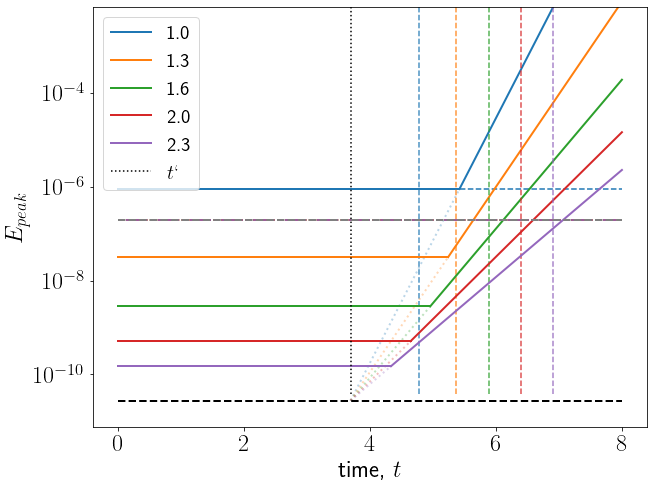

In [33]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})

for i, q in enumerate(qs[::3]):
    
    delta_t_q = (Es_q[::3][i]+24.31)*q/lambda_A
    t_q = t_prime + delta_t_q
    time1 = np.linspace(0, t_prime, 100)
    time2 = np.linspace(t_prime, t_q, 100)
    time3 = np.linspace(t_q, 8, 100)
    
    plot1 = ax.plot(time1, np.exp(np.ones_like(time1)*Es_q[::3][i]), linewidth = 2)#, color = colors_q[i])
    ax.plot(time2, np.exp(np.ones_like(time2)*Es_q[::3][i]), linewidth = 2, color = plot1[0].get_color())#, color = colors_q[i])
    
    ax.plot(time2, np.exp(E_t(time2, q)), linewidth = 2, color = plot1[0].get_color(), alpha = .3, linestyle = ':')#, color = colors_q[i])
    
    ax.plot(time3, np.exp(E_t(time3, q)), label = '%.1f'%q, linewidth = 2, color = plot1[0].get_color())#, color = colors_q[i])
    ax.vlines(times_act[:,::3][0, i], np.exp(-24), ax.get_ylim()[1], color = plot1[0].get_color(), linestyle = '--', alpha = .8)
    
    ax.hlines(np.exp(Es_act[:,::3][0, i]), 0, 8, color = plot1[0].get_color(), linestyle = '--')

ax.vlines(t_prime, np.exp(-24), ax.get_ylim()[1], color = 'black', linestyle = ':', label = r'$t`$')
ax.hlines([np.exp(E_pr), np.exp(Es_r[0])], time1[0], time3[-1], color = ['black', 'gray'], linestyle = '--', linewidth = 2)
#ax.legend(fontsize = 22, title = r'$q$', title_fontsize = 24)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'$E_{peak}$', yscale = 'log')
ax.set_ylim(top = np.exp(-5))
ax.legend(fontsize = 20, loc = 2)

(7.518907414366463e-12, 0.006737946999085467)

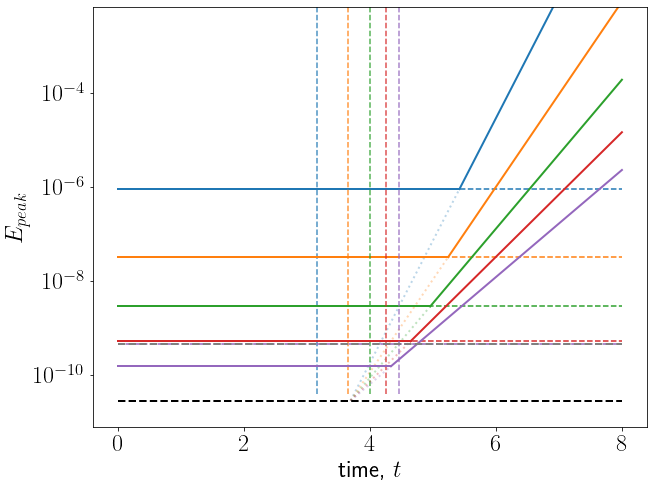

In [10]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})

for i, q in enumerate(qs[::3]):
    
    delta_t_q = (Es_q[::3][i]+24.31)*q/lambda_A
    t_q = t_prime + delta_t_q
    time1 = np.linspace(0, t_prime, 100)
    time2 = np.linspace(t_prime, t_q, 100)
    time3 = np.linspace(t_q, 8, 100)
    
    plot1 = ax.plot(time1, np.exp(np.ones_like(time1)*Es_q[::3][i]), linewidth = 2)#, color = colors_q[i])
    ax.plot(time2, np.exp(np.ones_like(time2)*Es_q[::3][i]), linewidth = 2, color = plot1[0].get_color())#, color = colors_q[i])
    
    ax.plot(time2, np.exp(E_t(time2, q)), label = '%.1f'%q, linewidth = 2, color = plot1[0].get_color(), alpha = .3, linestyle = ':')#, color = colors_q[i])
    
    ax.plot(time3, np.exp(E_t(time3, q)), label = '%.1f'%q, linewidth = 2, color = plot1[0].get_color())#, color = colors_q[i])
    ax.vlines(times_act[:,::3][5, i], np.exp(-24), ax.get_ylim()[1], color = plot1[0].get_color(), linestyle = '--', alpha = .8)
    
    ax.hlines(np.exp(Es_act[:,::3][5, i]), 0, 8, color = plot1[0].get_color(), linestyle = '--')

ax.hlines([np.exp(E_pr), np.exp(Es_r[5])], time1[0], time3[-1], color = ['black', 'gray'], linestyle = '--', linewidth = 2)
#ax.legend(fontsize = 22, title = r'$q$', title_fontsize = 24)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'$E_{peak}$', yscale = 'log')
ax.set_ylim(top = np.exp(-5))

(7.518907414366463e-12, 0.006737946999085467)

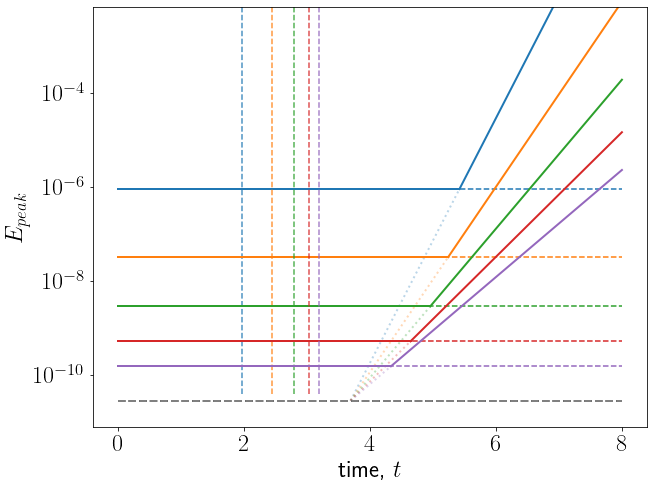

In [11]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})

for i, q in enumerate(qs[::3]):
    
    delta_t_q = (Es_q[::3][i]+24.31)*q/lambda_A
    t_q = t_prime + delta_t_q
    time1 = np.linspace(0, t_prime, 100)
    time2 = np.linspace(t_prime, t_q, 100)
    time3 = np.linspace(t_q, 8, 100)
    
    plot1 = ax.plot(time1, np.exp(np.ones_like(time1)*Es_q[::3][i]), linewidth = 2)#, color = colors_q[i])
    ax.plot(time2, np.exp(np.ones_like(time2)*Es_q[::3][i]), linewidth = 2, color = plot1[0].get_color())#, color = colors_q[i])
    
    ax.plot(time2, np.exp(E_t(time2, q)), label = '%.1f'%q, linewidth = 2, color = plot1[0].get_color(), alpha = .3, linestyle = ':')#, color = colors_q[i])
    
    ax.plot(time3, np.exp(E_t(time3, q)), label = '%.1f'%q, linewidth = 2, color = plot1[0].get_color())#, color = colors_q[i])
    ax.vlines(times_act[:,::3][-1, i], np.exp(-24), ax.get_ylim()[1], color = plot1[0].get_color(), linestyle = '--', alpha = .8)
    
    ax.hlines(np.exp(Es_act[:,::3][-1, i]), 0, 8, color = plot1[0].get_color(), linestyle = '--')

ax.hlines([np.exp(E_pr), np.exp(Es_r[-1])], time1[0], time3[-1], color = ['black', 'gray'], linestyle = '--', linewidth = 2)
#ax.legend(fontsize = 22, title = r'$q$', title_fontsize = 24)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'$E_{peak}$', yscale = 'log')
ax.set_ylim(top = np.exp(-5))

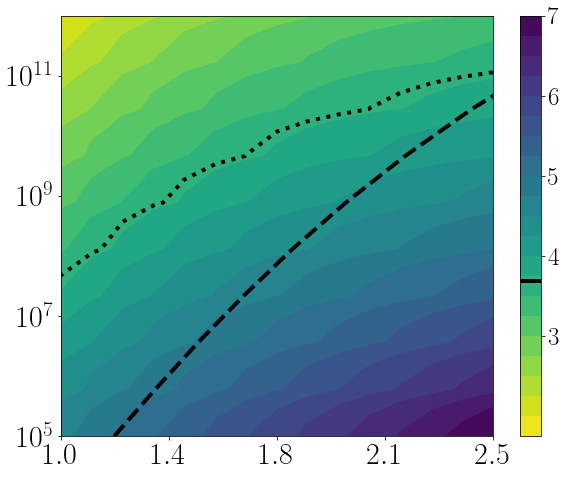

In [10]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
X, Y = np.meshgrid(qs, N_rs)
Z = X*Y
cs = AX.contourf(X, Y, times_act, levels = 20, cmap =plt.cm.viridis_r)
cs2 = AX.contour(cs, levels=[1/lambda_A*np.log((N_A*lambda_A)/(k_on*N_c))], colors='k', linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
#cbar.set_label('Activation time, $t_{act}$ [days]', fontsize = 33)
cbar.set_ticks(np.arange(3, Tf))
#cbar.set_ticklabels(np.flip(np.linspace(0,1,5)))
cbar.ax.tick_params(labelsize = 25)
cbar.add_lines(cs2)
AX.plot(qs_opt, N_rs, color = 'black', linewidth = 4, linestyle = 'dashed')
AX.set_xlim(left = 1, right = 2.5)
my_plot_layout(ax=AX, yscale = 'log', ticks_labelsize = 30)
AX.set_xticks(np.linspace(1, 2.5, 5))#
AX.set_xticklabels([r'$%.1f$'%(i) for i in np.linspace(1, 2.5, 5)])
FIG.savefig('../Figures/7_Recognition/activation_time.pdf')


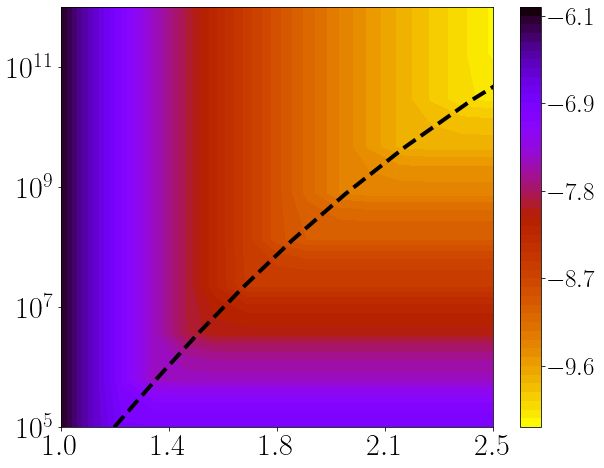

In [11]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
cs = AX.contourf(X, Y, Es_act, levels = 50, cmap =plt.cm.gnuplot_r)
#s2 = AX.contour(cs, levels=Es_q, linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
#cbar.set_label(r'Activation Affinity, $\log_{10}{K_{d}^{act}}$', fontsize = 31)
cbar.set_ticks(np.linspace(-22, -14, 5))
cbar.set_ticklabels([r'$%.1f$'%i for i in np.log10(np.exp(np.linspace(-22, -14, 5)))])
cbar.ax.tick_params(labelsize = 25)
#cbar.add_lines(cs2)
AX.plot(qs_opt, N_rs, color = 'black', linewidth = 4, linestyle = 'dashed')
AX.set_xlim(left = 1, right = 2.5)
my_plot_layout(ax=AX, yscale = 'log', ticks_labelsize = 30)
AX.set_xticks(np.linspace(1, 2.5, 5))#
AX.set_xticklabels([r'$%.1f$'%(i) for i in np.linspace(1, 2.5, 5)])#
FIG.savefig('../Figures/7_Recognition/activation_energy.pdf')


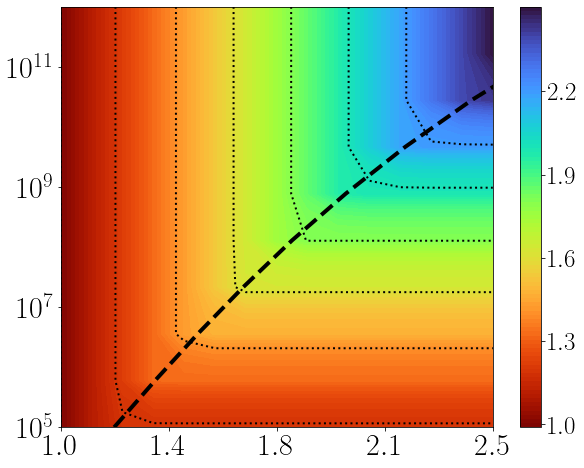

In [12]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
cs = AX.contourf(X, Y, betas_act, levels = 100, cmap =plt.cm.turbo_r)
cs2 = AX.contour(cs, levels=[1.001, 1.19, 1.4, 1.6, 1.8, 2, 2.2], linestyles = ':', linewidths = 2, colors = 'k')
#cs2 = AX.contour(cs, levels=1/betas_r[::5], linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
#cbar.set_label(r'Activation temperature, $\beta_{act}$', fontsize = 31)
cbar.set_ticks(np.linspace(1., 2.2, 5))
cbar.set_ticklabels([r'$%.1f$'%(i) for i in np.linspace(1., 2.2, 5)])
cbar.ax.tick_params(labelsize = 25)
#cbar.add_lines(cs2)
AX.plot(qs_opt, N_rs, color = 'black', linewidth = 4, linestyle = 'dashed')
AX.set_xlim(left = 1, right = 2.5)
my_plot_layout(ax=AX, yscale = 'log', ticks_labelsize = 30)
AX.set_xticks(np.linspace(1, 2.5, 5))#
AX.set_xticklabels([r'$%.1f$'%(i) for i in np.linspace(1, 2.5, 5)])
FIG.savefig('../Figures/7_Recognition/activation_temperature.pdf')


array([[ 3.2015749 ,  4.17162358,  5.11838841,  6.02963939,  6.89855263,
         7.72174235,  8.49814554,  9.22826733,  9.91363362, 10.55639245,
                nan,         nan,         nan,         nan,         nan],
       [ 3.2015749 ,  4.17162358,  5.11838841,  6.02963939,  6.89855263,
         7.72174235,  8.49814554,  9.22826733,  9.91363362, 10.55639245,
                nan,         nan,         nan,         nan,         nan],
       [ 3.2015749 ,  4.17162358,  5.11838841,  6.02963939,  6.89855263,
         7.72174235,  8.49814554,  9.22826733,  9.91363362, 10.55639245,
                nan,         nan,         nan,         nan,         nan],
       [ 3.2015749 ,  4.17162358,  5.11838841,  6.02963939,  6.89855263,
         7.72174235,  8.49814554,  9.22826733,  9.91363362, 10.55639245,
                nan,         nan,         nan,         nan,         nan],
       [ 3.2015749 ,  4.17162358,  5.11838841,  6.02963939,  6.89855263,
         7.72174235,  8.49814554,  9.22826733, 

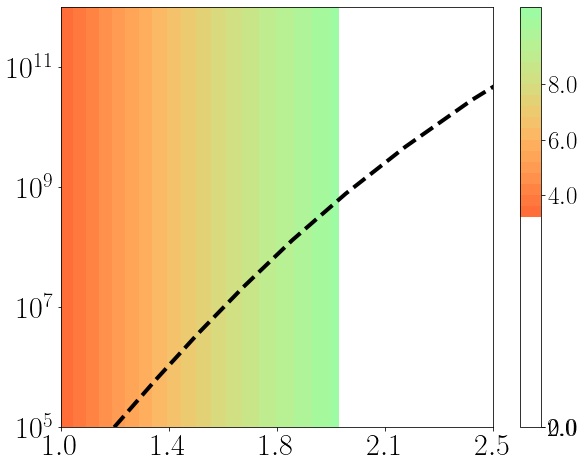

In [13]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
cs = AX.contourf(X, Y, Ds_KL_f, levels = 20, cmap =plt.cm.rainbow_r, vmin = 0, vmax = 24)
#cs2 = AX.contour(cs, levels=1/np.arange(1, 5), linestyles = '--', linewidths = 4, colors = 'k')
#cs2 = AX.contour(cs, levels=1/betas_r[::5], linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
#cbar.set_label(r'$\log(D_{KL})$', fontsize = 31)
cbar.set_ticks(np.linspace(0, 8, 5))#
cbar.set_ticklabels([r'$%.1f$'%(i) for i in np.linspace(0, 8, 5)])
cbar.ax.tick_params(labelsize = 25)
#cbar.add_lines(cs2)
AX.plot(qs_opt, N_rs, color = 'black', linewidth = 4, linestyle = 'dashed')
AX.set_xlim(left = 1, right = 2.5)
my_plot_layout(ax=AX, yscale = 'log', ticks_labelsize = 30)
AX.set_xticks(np.linspace(1, 2.5, 5))#
AX.set_xticklabels([r'$%.1f$'%(i) for i in np.linspace(1, 2.5, 5)])
FIG.savefig('../Figures/7_Recognition/D_KL_f.pdf')
Ds_KL_f

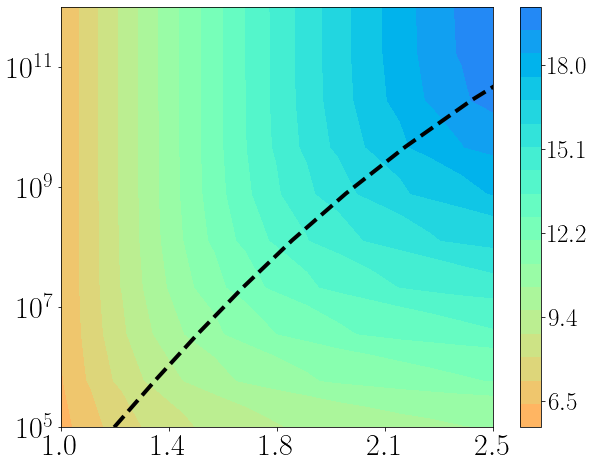

In [14]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
cs = AX.contourf(X, Y, Ds_KL_act, levels = 20, cmap =plt.cm.rainbow_r, vmin = 0, vmax = 24)
#cs2 = AX.contour(cs, levels=1/np.arange(1, 5), linestyles = '--', linewidths = 4, colors = 'k')
#cs2 = AX.contour(cs, levels=1/betas_r[::5], linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
#cbar.set_label(r'$\log(D_{KL})$', fontsize = 31)
cbar.set_ticks(np.linspace(6.5, 18, 5))#
cbar.set_ticklabels([r'$%.1f$'%(i) for i in np.linspace(6.5, 18, 5)])
cbar.ax.tick_params(labelsize = 25)
#cbar.add_lines(cs2)
AX.plot(qs_opt, N_rs, color = 'black', linewidth = 4, linestyle = 'dashed')
AX.set_xlim(left = 1, right = 2.5)
my_plot_layout(ax=AX, yscale = 'log', ticks_labelsize = 30)
AX.set_xticks(np.linspace(1, 2.5, 5))#
AX.set_xticklabels([r'$%.1f$'%(i) for i in np.linspace(1, 2.5, 5)])

FIG.savefig('../Figures/7_Recognition/D_KL_act.pdf')

In [55]:
np.cos(1.5*np.pi)

-1.8369701987210297e-16

In [78]:
a = np.array(['a', '*0', 'g', 'd'])
b = np.random.random((2, 5))
c = b[:, -1].argsort()
print(b)
print(c)

[[0.49214864 0.30130232 0.26231153 0.24916192 0.45971109]
 [0.90435716 0.46153587 0.65640728 0.17310312 0.89573413]]
[0 1]


In [67]:
a = a[c[::-1]]
b = b[c[::-1], :]

In [68]:
a, b

(array([['g', 'd'],
        ['d', '*0'],
        ['*0', 'g'],
        ['a', 'a']], dtype='<U2'),
 array([[[0.93503382, 0.37047331],
         [0.67433457, 0.85247631]],
 
        [[0.67433457, 0.85247631],
         [0.50654285, 0.44619323]],
 
        [[0.50654285, 0.44619323],
         [0.93503382, 0.37047331]],
 
        [[0.23811011, 0.13981975],
         [0.23811011, 0.13981975]]]))

In [2]:
b = np.array([3,6,1]).reshape((3, 1))
b.tolist()

[[3], [6], [1]]

In [5]:
bs = np.vstack([b]*4)
bs

array([[3],
       [6],
       [1],
       [3],
       [6],
       [1],
       [3],
       [6],
       [1],
       [3],
       [6],
       [1]])

In [34]:
f = np.arange(10)
g=np.random.randint(1, 10, 10)
print(g)
f[(g<=4) & (g>1)]

[8 7 5 9 5 9 2 8 8 1]


array([6])

In [38]:
np.sum(f)

1

In [10]:
t = np.linspace(0, 8)
t = 6
tb = 7
np.heaviside(t-tb, 1)

0.0

'4.22e+17'

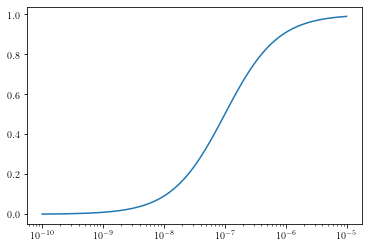

In [10]:
concentration = np.logspace(-10, -5, 100)
k_d = 1e-7
p_b = 1/(1+k_d/concentration)
plt.plot(concentration, p_b)
plt.xscale('log')
'%.2e'%(k_d*7*N_A)

In [15]:
'%.2e'%(np.exp(8*3)/1e3)

'2.65e+07'

In [56]:
'%.2e'%(np.exp(6*4.5)/1e3)

'5.32e+08'

In [59]:
lambda_A = 8
t_prime = 1/lambda_A*np.log((lambda_A*N_A)/(k_on*N_c))
t_prime, '%.2e'%(np.exp(lambda_A*(t_prime+1))/1e3)

(2.8052184499863633, '1.66e+10')

In [9]:
'%.2e'%(k_on/(24*3600)), '%.2e'%((1/20)/(k_on/(24*3600)))

('1.00e+06', '5.00e-08')

In [5]:
np.log(1e-6)

-13.815510557964274

In [16]:
(1/20)*3600

180.0

In [10]:
np.flip([1, 2, 3])

array([3, 2, 1])

In [13]:
'%.0e'%np.exp(10)

'2e+04'

In [15]:
k1 = 1e-5
c1 = 1e-9
k2 = 1e-5
c2 = 1e-9
p_b = lambda k, c : 1/(1+k/c)
p1 = p_b(k1, c1)
p2 = p_b(k2, c2)
p1, p2, 1-((1-p1)*(1-p2)), 1-((1-p_b(k1, 2*c1)))

(9.999000099990002e-05,
 9.999000099990002e-05,
 0.0001999700039995167,
 0.00019996000799837876)

In [36]:
(((1e6*24*3600)/24)*1e-5)**(-1)

2.777777777777778e-05

In [113]:
A = np.ones((2, 3))
A[1,2] = 3
A[0,2] = 4
A = np.array([1,5,93,7,9,33])
np.flip(np.argsort(A))


array([2, 5, 4, 3, 1, 0])

In [104]:
np.divide(A.T, (np.array([4, 2]))).T

array([[0.25, 0.25, 1.  ],
       [0.5 , 0.5 , 1.5 ]])

In [5]:
N_r = 2e3

print(r'$%.0f\cdot 10^{%d}$'%(10**(np.log10(N_r)%1), int(np.log10(N_r))))

$2\cdot 10^{3}$
